# 2019 AAPOR Text Analytics Tutorial
### Patrick van Kessel
#### Senior Data Scientist, Pew Research Center

These materials are adapted from workshops I did in 2018 and 2019 for NYAAPOR, the World Bank, and IBM, with a lot of help from an old colleague of mine, Michael Jugovich (now at IBM). You can access a GitHub repository containing this notebook and the data sample here: https://github.com/patrickvankessel/AAPOR-Text-Analysis-2019 

## Loading in the data

We'll use a sample from the Kaggle Amazon Fine Food Reviews dataset. The full dataset can be found here: https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [0]:
import pandas as pd

In [0]:
sample = pd.read_csv("https://raw.githubusercontent.com/patrickvankessel/AAPOR-Text-Analysis-2019/master/kaggle_sample.csv")

In [3]:
print(len(sample))

10000


Let's see what's in here.

In [4]:
sample.head()

,Unnamed: 0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,467510,467511,B003WECB5S,A2G0LDLGXKQFYP,behrlekidsmom,2,2,3,1304640000,Holes in wrappers,The kids said the taste/flavor is fine but A L...
1,1,291775,291776,B000FVYUFA,A34O5D0QRGV29N,a Dallas reader,1,1,5,1188432000,Absolutely the best!,How can something this good be good for you to...
2,2,180629,180630,B000CQBZQK,A3ER3V2E06DH7D,"A. K. Kaw ""AKK""",0,1,5,1247529600,Tea meant for a late evening,"I love Earl Grey Tea. I have tried Tazo, Twini..."
3,3,412055,412056,B000CQC05K,A39Y02EJ310WJR,"Tech Girl ""Wendy""",2,2,5,1236729600,"Full-flavored, delicious tea that you can drin...",This tea is so fruity and full-flavored that i...
4,4,139779,139780,B001BCXTGS,A1LC1NMRA1ZEDZ,M. Garcia,1,1,5,1244332800,My cat only eats this brand,My cat is not crazy about the snapper and shri...


### Examine the data

Run the cell below a few times, let's take a look at our text and see what it looks like.  Always take a look at your raw data.

In [5]:
sample.sample(10)['Text'].values

array(['These are simply the best treats.  They are healthy and my dog LOVES them.  He is a very finicky eater and has digestive problems, so when I find something good - I order in bulk.  These are great - with no guilt!',
       "I don't know why these aren't sold in stores (at least around my area), they are the best flavor of Nature Valley Granola Bars.",
       'Very smooth with no after taste. I took a box to my office and it quickly became the favorite coffee mate cream.',
       'PROS:  good odor control, little dust, pleasant appearance, tracking is decent and the smooth crystals don\'t hurt little paws or bare feet.<br /><br />CONS:  expensive, can\'t find this brand in any stores nearby if I run out and with two kitties (one with chronic diarrhea), I tend to use A LOT so it adds up in cost.<br /><br />Since getting my kitties a few months ago I\'ve tried several different litters and am happiest with Ultra Pearls (smooth shape).  They are expensive, but that is the price I\'

### Preprocess the text (clean it up!)

I don't know about you, but I noticed some junk in our data - HTML and URLs.  Let's clear that out first.  We'll also take this opportunity to lemmatize the words - to do that, we'll install NLTK's WordNet library.

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
import re
from nltk.stem import WordNetLemmatizer

# Initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # First we'll use regular expressions to strip out links and HTML tags
    text = re.sub(r'http[a-zA-Z0-9\&\?\=\?\/\:\.]+\b', ' ', text)
    text = re.sub(r'\<[^\<\>]+\>', ' ', text)
    # Next, let's clear out all punctuation and replace it with whitespace
    text = re.sub(r'\W+', ' ', text) 
    # And then lowercase
    text = text.lower()
    # This isn't going to be perfect - ideally we expand contractions first
    # And also deal with spelling corrections
    # But this will work well enough for now
    
    # Next, let's split on whitespace and then lemmatize each token
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(x) for x in tokens]
    text = " ".join(tokens)
  
    return text

sample['Text'] = sample['Text'].map(clean_text)

Let's see what our data look like now that we've processed the text

In [8]:
sample.sample(10)['Text'].values

array(['my husband wanted this coffee maker not me i thought it wa too expensive still do and the coffee wa too expensive still do we bought the newman s decaf and really liked it when we were in a hurry the coffee maker is great i decided to give another decaf a try and tried emeril s jazzed up decaf it is a great coffee no after taste and a good rich coffee my son who drink only reg coffee doe not know the difference with emeril s it s still over priced but it s good i am not a big coffee drinker one cup in the morning is about it but i like this one',
       'this is a wonderful cup of coffee no matter what time of day you drink it it is so smooth and not bitter after dinner it is like having a desert the sale price i paid wa impossible to beat thank you amazon this flavor is one one of my very favorite i love my keurig coffee maker',
       'a quick way to make good sushi at home all you need is the vegetable and meat everything else is in the kit fast to prepare',
       'these ar

## TF-IDF Vectorization (Feature Extraction)

Just to be safe, let's add some additional words to a standard list of English stop words.

In [0]:
from sklearn.feature_extraction import stop_words as sklearn_stop_words
# Grab standard English stopwords
stop_words = set(sklearn_stop_words.ENGLISH_STOP_WORDS)
# And add in some of our own
stop_words = stop_words.union(set([
    "www", "http", "https", "br", "amazon", "href", "wa", "ha"
]))

Okay, now let's tokenize our text and turn it into numbers

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, # Remove any words that appear in more than 90% of our documents
    min_df=5, # Remove words that appear in fewer than 5 document
    ngram_range=(1, 1), # Only extract unigrams
    stop_words=stop_words, # Remove stopwords
    max_features=2500 # Grab the 2500 most common words (based on above constraints)
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

In [11]:
tfidf

<10000x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 253177 stored elements in Compressed Sparse Row format>

Because words are really big, by default we work with sparse matrices.  We can expand the sparse matrix with `.todense()` and compute sums like a normal dataframe.  Let's check out the top 20 words.

In [12]:
ngram_df = pd.DataFrame(tfidf.todense(), columns=ngrams) 
ngram_df.sum().sort_values(ascending=False)[:20]

like       320.322071
coffee     314.590534
good       306.346477
taste      303.648918
great      294.419698
tea        285.204658
love       281.993501
product    279.948502
flavor     276.506974
just       235.293939
food       212.165279
dog        204.843193
really     177.518550
price      173.636666
time       164.651516
make       164.497317
cup        163.469380
buy        161.814995
best       160.949135
bag        153.382045
dtype: float64

## Classification

Let's make an outcome variable.  How about we try to predict 5-star reviews, and then maybe helpfulness?

In [0]:
sample['good_score'] = sample['Score'].map(lambda x: 1 if x == 5 else 0)
sample['was_helpful'] = ((sample['HelpfulnessNumerator'] / sample['HelpfulnessDenominator']).fillna(0.0) > .80).astype(int)

In [0]:
column_to_predict = 'good_score'

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import metrics

results = []
kfolds = StratifiedKFold(n_splits=5)

We just created an object that'll split the data into fifths, and then iterate over it five times, holding out one-fifth each time for testing.  Let's do that now.  Each "fold" contains an index for training rows, and one for testing rows.  For each fold, we'll train a basic linear Support Vector Machine, and evaluate its performance.

In [16]:
for i, fold in enumerate(kfolds.split(tfidf, sample[column_to_predict])):
    
    train, test = fold 
    print("Running new fold, {} training cases, {} testing cases".format(len(train), len(test)))
    
    clf = svm.LinearSVC(
        max_iter=1000,
        penalty='l2',
        class_weight='balanced',
        loss='squared_hinge'
    )
    # We picked some decent starting parameters, but you can try out different ones
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html 
    # If you're ambitious - check out the Scikit-Learn documentation and test out different models
    # http://scikit-learn.org/stable/supervised_learning.html
    # XGBoost is one of my favorites, and there's an Scikit-Learn wrapper for it
    # https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
    
    training_text = tfidf[train]
    training_outcomes = sample[column_to_predict].loc[train]
    clf.fit(training_text, training_outcomes) # Train the classifier on the training data
    
    test_text = tfidf[test]
    test_outcomes = sample[column_to_predict].loc[test]
    predictions = clf.predict(test_text) # Get predictions for the test data
    
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(
        test_outcomes, # Compare the predictions against the true outcomes
        predictions
    )
    
    results.append({
        "fold": i,
        "outcome": 0,
        "precision": precision[0],
        "recall": recall[0],
        "fscore": fscore[0],
        "support": support[0]
    })
    
    results.append({
        "fold": i,
        "outcome": 1,
        "precision": precision[1],
        "recall": recall[1],
        "fscore": fscore[1],
        "support": support[1]
    })
    
results = pd.DataFrame(results)

Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases


How'd we do?

In [17]:
print(results.groupby("outcome").mean()[['precision', 'recall']])
print(results.groupby("outcome").std()[['precision', 'recall']])

         precision    recall
outcome                     
0         0.639456  0.697674
1         0.816236  0.773365
         precision    recall
outcome                     
0         0.010269  0.014380
1         0.007468  0.008406


Now we know that our model is pretty stable and reasonably performant, we can fit and transform the full dataset.

In [18]:
clf.fit(tfidf, sample[column_to_predict])  
print(metrics.classification_report(sample[column_to_predict].loc[test], predictions))
print(metrics.confusion_matrix(sample[column_to_predict].loc[test], predictions))

              precision    recall  f1-score   support

           0       0.64      0.71      0.67       731
           1       0.82      0.77      0.79      1269

    accuracy                           0.75      2000
   macro avg       0.73      0.74      0.73      2000
weighted avg       0.75      0.75      0.75      2000

[[521 210]
 [298 971]]


And now we can see what the most predictive features are.

In [19]:
import numpy as np

ngram_coefs = sorted(zip(ngrams, clf.coef_[0]), key=lambda x: x[1], reverse=True)
ngram_coefs[:10]

[('highly', 3.0783038859825864),
 ('best', 2.4898490541238596),
 ('love', 2.3261940003743473),
 ('perfect', 2.289348501822659),
 ('favorite', 2.1284224025497416),
 ('wonderful', 2.07501846415182),
 ('cancer', 1.9305447689912651),
 ('fabulous', 1.8998909029502213),
 ('addicted', 1.863577244340993),
 ('european', 1.8319565370713156)]

What happens if you change the outcome column to "was_helpful" and re-run it again?  Can you think of ways to improve this?  Add more stopwords?  Include bigrams in addition to unigrams?

## Topic Modeling

In [0]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [0]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #{}: {}".format(
            topic_idx,
            ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        ))

Let's find some topics.  We'll check out non-negative matrix factorization (NMF) first.

In [22]:
nmf = NMF(n_components=10, random_state=42, alpha=.1, l1_ratio=.5).fit(tfidf)
# Try out different numbers of topics (change n_components)
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
print("\nTopics in NMF model:")
print_top_words(nmf, ngrams, 10)


Topics in NMF model:
Topic #0: like, taste, flavor, just, really, don, sugar, water, make, ve
Topic #1: coffee, cup, strong, roast, bold, flavor, blend, keurig, pod, like
Topic #2: tea, green, bag, drink, cup, iced, stash, black, earl, taste
Topic #3: dog, treat, love, food, chew, bone, small, size, teeth, training
Topic #4: cat, food, eat, dry, wellness, canned, chicken, ingredient, vet, wet
Topic #5: product, great, price, store, buy, love, order, shipping, time, local
Topic #6: bar, snack, protein, nut, calorie, peanut, healthy, candy, sweet, fat
Topic #7: chocolate, dark, hot, cooky, milk, cocoa, white, best, tasted, cookie
Topic #8: chip, bag, salt, potato, snack, kettle, vinegar, flavor, love, salty
Topic #9: good, really, price, pretty, taste, quality, quite, fresh, tasting, enjoy


LDA is an other popular topic modeling technique

In [23]:
lda = LatentDirichletAllocation(n_components=10, random_state=42).fit(tfidf)
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
# doc_topic_prior (alpha) - lower alpha means documents will be composed of fewer topics (higher means a more uniform distriution across all topics)
# topic_word_prior (beta) - lower beta means topics will be composed of fewer words (higher means a more uniform distribution across all words)
print("\nTopics in LDA model:")
print_top_words(lda, ngrams, 10)


Topics in LDA model:
Topic #0: chocolate, bar, snack, kid, great, like, candy, taste, sweet, good
Topic #1: dog, treat, chew, love, toy, bone, training, hair, teeth, pill
Topic #2: pretzel, jack, nut, licorice, pomegranate, link, temptation, broccoli, pistachio, black
Topic #3: taste, like, good, great, flavor, just, love, chip, product, snack
Topic #4: gift, arrived, great, jerky, product, order, received, christmas, item, good
Topic #5: tea, hot, taste, flavor, drink, like, love, great, good, green
Topic #6: popcorn, chocolate, product, box, like, bag, just, good, date, order
Topic #7: coffee, cup, flavor, taste, like, good, strong, roast, great, drink
Topic #8: product, price, store, buy, box, good, bag, taste, great, like
Topic #9: food, cat, dog, love, treat, product, eat, year, price, good


We can use the topic models the same way we did our classifier - everything in Scikit-Learn follows the same fit/transform paradigm.  So, let's get the topics for our documents.

In [0]:
doc_topics = pd.DataFrame(lda.transform(tfidf))

In [25]:
doc_topics.head()

,0,1,2,3,4,5,6,7,8,9
0,0.522646,0.024104,0.024094,0.024104,0.024096,0.024099,0.284551,0.024104,0.024103,0.024099
1,0.027765,0.027764,0.027761,0.027767,0.027764,0.027767,0.027767,0.750109,0.027769,0.027767
2,0.016935,0.016939,0.016935,0.016940,0.016935,0.847561,0.016942,0.016939,0.016937,0.016937
3,0.023145,0.023149,0.023144,0.023148,0.023147,0.791679,0.023146,0.023150,0.023147,0.023146
4,0.021646,0.021650,0.021646,0.476330,0.021646,0.021648,0.021648,0.021648,0.021648,0.350490


In [0]:
topic_column_names = ["topic_{}".format(c) for c in doc_topics.columns]
doc_topics.columns = topic_column_names

Next we use Pandas to join the topics with the original sample dataframe

In [0]:
sample_with_topics = pd.concat([sample, doc_topics], axis=1)

Let's look for patterns by running some means and correlations

In [28]:
topic_columns = [col for col in sample_with_topics.columns if col.startswith("topic_")]
sample_with_topics.groupby("good_score").mean()[topic_columns]

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
good_score,,,,,,,,,,
0,0.046504,0.049866,0.025134,0.259905,0.038543,0.092013,0.113540,0.163749,0.121633,0.089114
1,0.048933,0.055559,0.028447,0.291643,0.060745,0.115629,0.069795,0.140131,0.077924,0.111194


In [29]:
for topic in topic_column_names:
    print("{}: {}".format(topic, sample_with_topics[topic].corr(sample_with_topics['Score'])))

topic_0: 0.025519441578261363
topic_1: 0.020769454794250783
topic_2: 0.026663898691414133
topic_3: 0.06361757176393044
topic_4: 0.07871292782698457
topic_5: 0.0655971250900742
topic_6: -0.15351752883902653
topic_7: 0.005095615596520921
topic_8: -0.15711097639240978
topic_9: 0.023032254801414076


Here's an example of a linear regression

In [30]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

training_data = sample_with_topics[topic_column_names[:-1]] 
# We're leaving a column out to avoid multicollinearity

regression = linear_model.LinearRegression()

# Train the model using the training sets
regression.fit(training_data, sample_with_topics['Score'])
coefficients = regression.coef_
for topic, coef in zip(topic_column_names[:-1], coefficients):
  print("{}: {}".format(topic, coef))

topic_0: 0.15149725353494317
topic_1: 0.08751416056341133
topic_2: 0.42051281916259403
topic_3: 0.03660310963829044
topic_4: 0.6524498317679657
topic_5: 0.22648892211578306
topic_6: -1.1120620186256902
topic_7: -0.10002067164872161
topic_8: -1.0832382962675375


Sadly Scikit-Learn doesn't make it easy to get p-values or a regression report like you'd normally expect of something like R or Stata.  Scikit-Learn is more about prediction than statistical analysis; for the latter, we can use Statsmodels.  

In [31]:
import statsmodels.api as sm

regression = sm.OLS(sample_with_topics['Score'], training_data)
results = regression.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              6961.
Date:                Fri, 06 Dec 2019   Prob (F-statistic):                        0.00
Time:                        19:02:10   Log-Likelihood:                         -19021.
No. Observations:               10000   AIC:                                  3.806e+04
Df Residuals:                    9991   BIC:                                  3.812e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### K-Means Clustering

We can also check out other unsupervised methods like clustering.  I borrowed/modified some of this code from http://brandonrose.org/clustering

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, max_iter=50, tol=.01, n_jobs=-1)
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans.fit(tfidf)
clusters = kmeans.labels_.tolist() # You can merge these back into the data if you want

In [33]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 
for i, closest_ngrams in enumerate(centroids):
    print("Cluster #{}: {}".format(i, ", ".join(np.array(ngrams)[closest_ngrams[:8]])))

Cluster #0: cat, food, eat, love, treat, chicken, wellness, dry
Cluster #1: product, price, great, store, good, buy, grocery, local
Cluster #2: tea, taste, green, bag, drink, flavor, like, good
Cluster #3: sauce, hot, pasta, taste, chicken, great, spicy, good
Cluster #4: taste, like, flavor, chocolate, good, sugar, drink, just
Cluster #5: dog, treat, food, love, chew, like, product, good
Cluster #6: bar, chocolate, snack, like, taste, nut, protein, good
Cluster #7: coffee, cup, flavor, like, strong, roast, good, taste
Cluster #8: chip, potato, bag, flavor, snack, kettle, salt, like
Cluster #9: love, great, just, good, time, like, make, bag


### Agglomerative/Hierarchical Clustering

Instead of specifying the number of clusters upfront, now we're going to use hierarchical clustering to characterize how similar words are to each other, again based on their co-occurrence within documents. To keep things manageable, we'll use a smaller set of 500 words.

In [0]:
# This Python library lets us produce graphics
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.25, # Focus on less common, more unique words
    min_df=5, 
    ngram_range=(1, 1), 
    stop_words=stop_words, 
    max_features=200 # <- smaller set of words
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

In [0]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

# We'll use cosine similarity to get word similarities based on document overlap
# This produces a matrix of every word compared to every other word
# With a value of 0 - 1, indicating how often they occur together in the same documents
# To get document similarities in terms of word overlap, just drop the .transpose()!
similarities = cosine_similarity(tfidf.transpose()) 
distances = 1 - similarities # Converts to distances
clusters = linkage(distances, method='ward') # Run hierarchical clustering on the distances

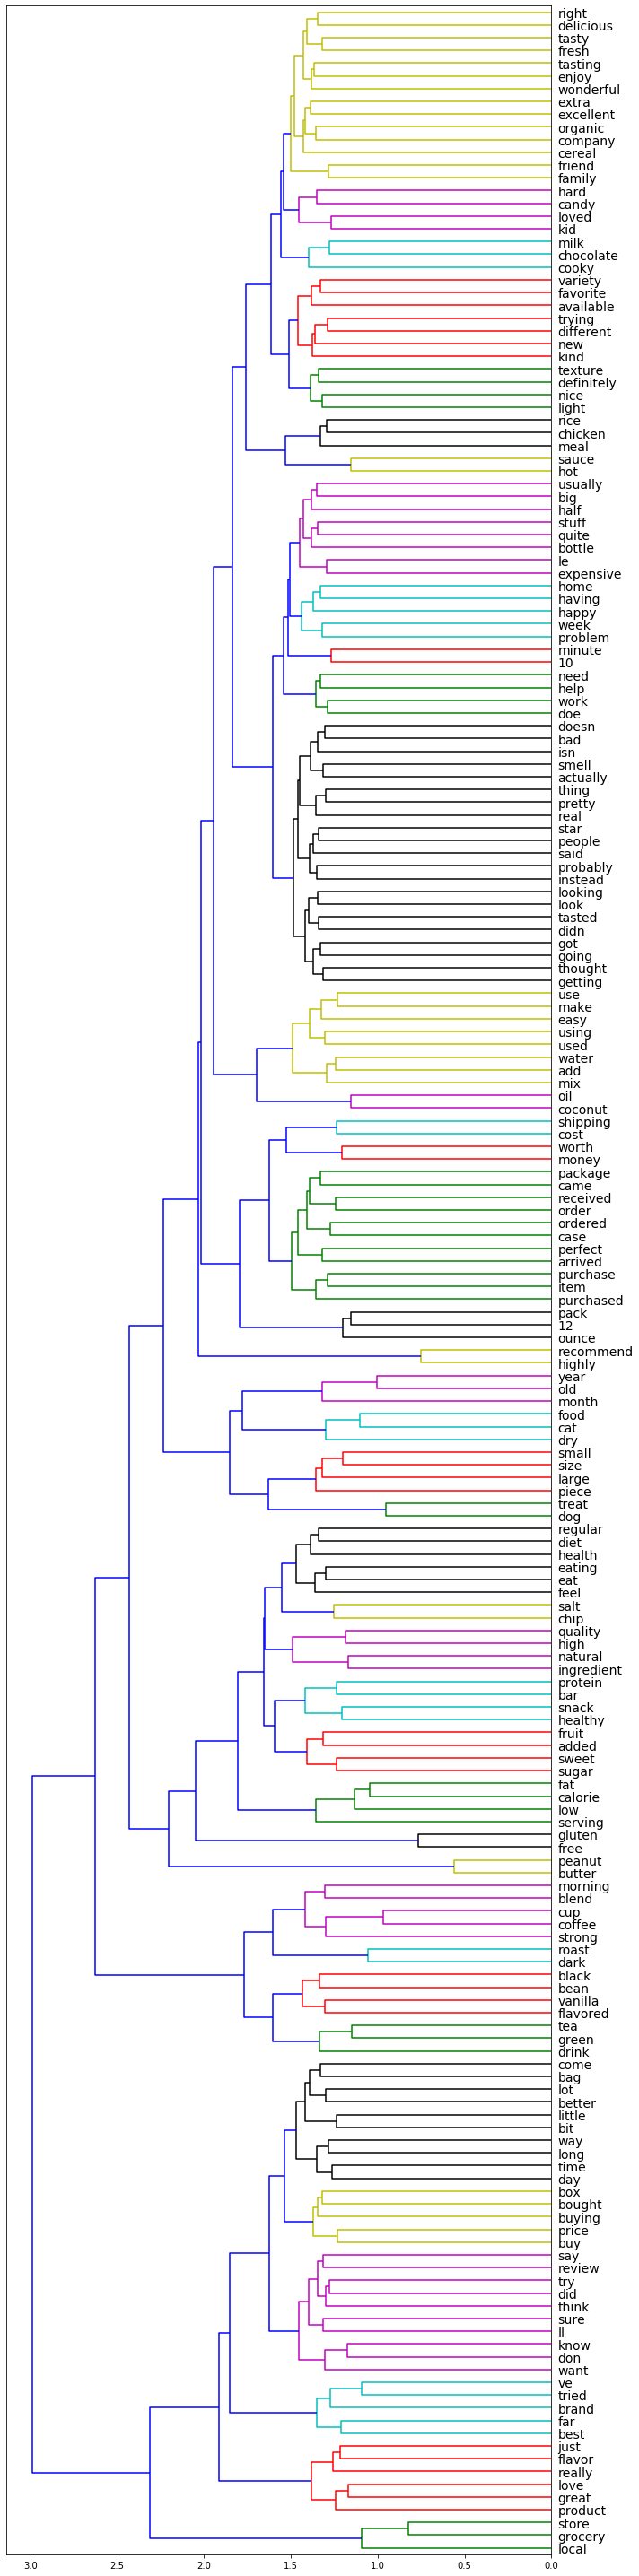

In [37]:
fig, ax = plt.subplots(figsize=(10, 40))
ax = dendrogram(
    clusters, 
    labels=ngrams, 
    orientation="left", 
    leaf_font_size=14, 
    color_threshold=1.5
)
plt.tight_layout()